# **MNIST Classification using FCNN and CNN in PyTorch**
--------------------------------------------------
This tutorial demonstrates how to:

* Load and preprocess the MNIST dataset
* Build two models - FCNN and CNN
* Train and evaluate the models
* Save and load trained models
* Compute confusion matrix, precision, recall, and F1-score
* Plot training loss vs epochs




# **1. IMPORT LIBRARIES**

In [ ]:
# ======================================================
# 1. IMPORT LIBRARIES
# ======================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import time


# **2. SETUP**

In [ ]:
# ======================================================
# 2. SETUP
# ======================================================
BATCH_SIZE = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔥 Using device: {DEVICE}")

🔥 Using device: cpu


# **3. LOAD AND PREPROCESS MNIST DATA**

In [ ]:
# ======================================================
# 3. LOAD AND PREPROCESS MNIST DATA
# ======================================================
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensor
    transforms.Normalize((0.1307,), (0.3081,)) # and normalize it [0, 255] → [0.0, 1.0] (by dividing by 255).  mean = 0.1307  std = 0.3081
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Testing samples : {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.88MB/s]

✅ Training samples: 60000
✅ Testing samples : 10000


# **4. MODEL DEFINITIONS**

In [ ]:
# ======================================================
# 4. MODEL DEFINITIONS
# ======================================================
# --- Fully Connected Neural Network (FCNN) ---
class FCNN(nn.Module):                    #defining your own neural network class
    def __init__(self, input_size=784, num_classes=10):         # __init__ initializes the layers of your model.
        super(FCNN, self).__init__()              # calls the parent class (nn.Module) constructor — necessary to properly set up the model.
        self.fc1 = nn.Linear(input_size, 128)  # defining FC1 LAYER
        self.fc2 = nn.Linear(128, 64)          # defining FC2 LAYER
        self.fc3 = nn.Linear(64, num_classes)    # defining FC3 LAYER

    def forward(self, x):             # Forward Pass (How Data Flows)
        x = x.view(x.size(0), -1)  # Flatten input Converts each 28×28 image → a 784-dimensional vector (flattens it).
        x = F.relu(self.fc1(x))  # Passes data through first layer (fc1) AND THEN RELU ACTIVATION FUNCTION
        x = F.relu(self.fc2(x))  # # Passes data through SECOND layer (fc2) AND THEN RELU ACTIVATION FUNCTION
        x = self.fc3(x)
        return x

# --- Convolutional Neural Network (CNN) ---
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)   # flatten it
        x = self.fc(x)
        return x

# Helper function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# **5. TRAINING AND TESTING FUNCTIONS**

In [ ]:
# ======================================================
# 5. TRAINING AND TESTING FUNCTIONS
# ======================================================
def train_model(model, train_loader, optimizer, epoch):
    """Train model for one epoch and return average loss"""
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() #Clears old gradients
        output = model(data)   # Forward pass — model predicts output
        loss = F.cross_entropy(output, target)
        loss.backward() # Compute gradients (backpropagation)
        optimizer.step() # Update model weights using gradients
        running_loss += loss.item() # # Add the current batch loss to running total (convert tensor to float using .item())
    avg_loss = running_loss / len(train_loader) # Compute average loss over all batches
    print(f"🧠 Epoch [{epoch}] - Train Loss: {avg_loss:.4f}")
    return avg_loss

def test_model(model, test_loader):
    """Evaluate model and compute accuracy"""
    model.eval()
    test_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            preds = output.argmax(dim=1) # Select class with max probability
            correct += preds.eq(target).sum().item() #  Count how many predictions were correct
            all_preds.extend(preds.cpu().numpy()) # Store predictions and true labels for future use (e.g., confusion matrix)
            all_labels.extend(target.cpu().numpy()) # # Store predictions and true labels for future use (e.g., confusion matrix)
    test_loss /= len(test_loader.dataset) # Compute average loss per sample across the entire test dataset
    acc = 100. * correct / len(test_loader.dataset)  # Compute Accuracy
    print(f"✅ Test Loss: {test_loss:.4f} | Accuracy: {acc:.2f}%")
    return acc, np.array(all_preds), np.array(all_labels)

# **6. TRAIN FCNN MODEL**

In [ ]:
# ======================================================
# 6. TRAIN FCNN MODEL
# ======================================================
print("\n===============================")
print("🚀 TRAINING FCNN MODEL")
print("===============================")

fcnn_model = FCNN().to(DEVICE)
fcnn_optimizer = optim.Adam(fcnn_model.parameters(), lr=LEARNING_RATE)
fcnn_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    loss = train_model(fcnn_model, train_loader, fcnn_optimizer, epoch)
    fcnn_losses.append(loss)

# Save FCNN model
torch.save(fcnn_model.state_dict(), "fcnn_mnist.pth")
print("💾 FCNN model saved as 'fcnn_mnist.pth'")

# Evaluate FCNN
fcnn_acc, fcnn_preds, fcnn_labels = test_model(fcnn_model, test_loader)


🚀 TRAINING FCNN MODEL
🧠 Epoch [1] - Train Loss: 0.2669
🧠 Epoch [2] - Train Loss: 0.1140
🧠 Epoch [3] - Train Loss: 0.0791
🧠 Epoch [4] - Train Loss: 0.0601
🧠 Epoch [5] - Train Loss: 0.0491
💾 FCNN model saved as 'fcnn_mnist.pth'
✅ Test Loss: 0.0889 | Accuracy: 97.63%


# **7. TRAIN CNN MODEL**

In [ ]:
# ======================================================
# 7. TRAIN CNN MODEL
# ======================================================
print("\n===============================")
print("🚀 TRAINING CNN MODEL")
print("===============================")

cnn_model = SimpleCNN().to(DEVICE)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
cnn_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    loss = train_model(cnn_model, train_loader, cnn_optimizer, epoch)
    cnn_losses.append(loss)

# Save CNN model
torch.save(cnn_model.state_dict(), "cnn_mnist.pth")
print("💾 CNN model saved as 'cnn_mnist.pth'")

# Evaluate CNN
cnn_acc, cnn_preds, cnn_labels = test_model(cnn_model, test_loader)


🚀 TRAINING CNN MODEL
🧠 Epoch [1] - Train Loss: 0.1349
🧠 Epoch [2] - Train Loss: 0.0444
🧠 Epoch [3] - Train Loss: 0.0327
🧠 Epoch [4] - Train Loss: 0.0250
🧠 Epoch [5] - Train Loss: 0.0187
💾 CNN model saved as 'cnn_mnist.pth'
✅ Test Loss: 0.0313 | Accuracy: 98.94%


# **8. PLOT EPOCH VS LOSS CURVES**

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


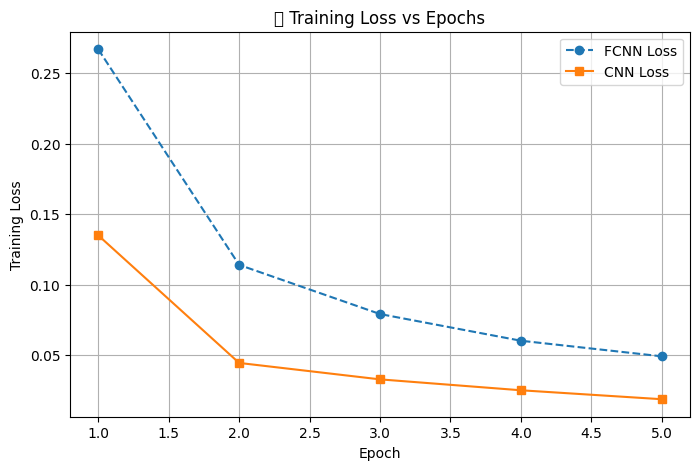

In [ ]:
# ======================================================
# 8. PLOT EPOCH VS LOSS CURVES
# ======================================================
plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), fcnn_losses, 'o--', label='FCNN Loss')
plt.plot(range(1, NUM_EPOCHS + 1), cnn_losses, 's-', label='CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('📉 Training Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# **9. EVALUATION: CONFUSION MATRIX & METRICS (CNN)**


📊 CNN MODEL PERFORMANCE METRICS
--------------------------------
              precision    recall  f1-score   support

           0     0.9909    0.9969    0.9939       980
           1     0.9973    0.9877    0.9925      1135
           2     0.9864    0.9874    0.9869      1032
           3     0.9960    0.9861    0.9910      1010
           4     0.9888    0.9908    0.9898       982
           5     0.9737    0.9944    0.9839       892
           6     0.9886    0.9916    0.9901       958
           7     0.9874    0.9922    0.9898      1028
           8     0.9907    0.9887    0.9897       974
           9     0.9920    0.9792    0.9855      1009

    accuracy                         0.9894     10000
   macro avg     0.9892    0.9895    0.9893     10000
weighted avg     0.9894    0.9894    0.9894     10000



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


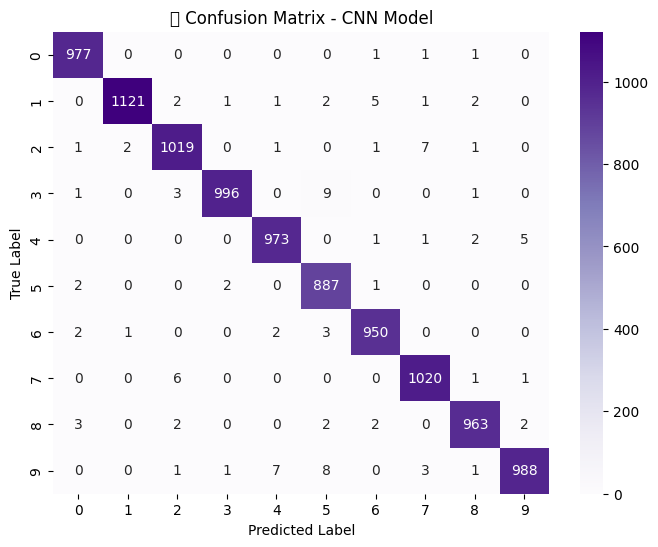

In [ ]:
# ======================================================
# 9. EVALUATION: CONFUSION MATRIX & METRICS (CNN)
# ======================================================
print("\n📊 CNN MODEL PERFORMANCE METRICS")
print("--------------------------------")
print(classification_report(cnn_labels, cnn_preds, digits=4))

cm = confusion_matrix(cnn_labels, cnn_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title("🧩 Confusion Matrix - CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **10. LOAD SAVED MODEL & VERIFY**

In [ ]:
# ======================================================
# 10. LOAD SAVED MODEL & VERIFY
# ======================================================
print("\n📦 Loading saved CNN model and re-evaluating...")
loaded_cnn = SimpleCNN().to(DEVICE)
loaded_cnn.load_state_dict(torch.load("cnn_mnist.pth"))
loaded_cnn.eval()
_, loaded_preds, loaded_labels = test_model(loaded_cnn, test_loader)
print("✅ Model reloaded successfully and produces same accuracy!")


📦 Loading saved CNN model and re-evaluating...
✅ Test Loss: 0.0313 | Accuracy: 98.94%
✅ Model reloaded successfully and produces same accuracy!


# **11. FINAL RESULTS SUMMARY**

In [ ]:
# ======================================================
# 11. FINAL RESULTS SUMMARY
# ======================================================
print("\n===============================")
print("🏁 FINAL RESULTS SUMMARY")
print("===============================")
print(f"FCNN Accuracy: {fcnn_acc:.2f}%")
print(f"CNN Accuracy : {cnn_acc:.2f}%")

if cnn_acc > fcnn_acc:
    print("\n🎯 CNN outperforms FCNN — it captures spatial features better!")
else:
    print("\n⚠️ FCNN performed better — try increasing epochs or tuning hyperparameters.")


🏁 FINAL RESULTS SUMMARY
FCNN Accuracy: 97.63%
CNN Accuracy : 98.94%

🎯 CNN outperforms FCNN — it captures spatial features better!
